# CSCN8020 — Assignment 1
**Student Name:** Yogesh Kumar Gopal  
**Student ID:** 8996403  
**Course:** Reinforcement Learning Programming 

## Problem 1: Pick and Place Robot as an MDP

The pick and place robot control problem can be formulated as a Markov Decision Process (MDP):

- **States:** Describe the robot's current joint positions and velocities as continuous values, along with whether the gripper is holding an object.

- **Actions:** The robot controls its motors directly by issuing continuous motor commands or torques for each joint.

- **Rewards:**  
  +10 for successfully placing the object at the goal,  
  -1 for each time step to encourage speed,  
  A penalty for sudden changes in acceleration or torque (which encourages smooth movement), and  
  -5 for any failures such as dropping the object.

- **Episode Ends:** When the object is placed successfully, a failure occurs, or a time limit is reached.

This MDP setup ensures the robot learns to move quickly and smoothly while successfully completing the pick and place task.
This setup helps the robot learn to pick and place objects efficiently and smoothly by adjusting motor commands directly.



In [64]:

class PickPlaceRobotEnv:
    def __init__(self):
        # State: (position, holding)
        # position: 0 = at pick, 1 = at place
        # holding: 0 = not holding, 1 = holding object
        self.states = [(0, 0), (0, 1), (1, 0), (1, 1)]
        self.state = (0, 0)
        self.steps = 0
    
    def reset(self):
        self.state = (0, 0)
        self.steps = 0
        return self.state
    
    def step(self, action):
        pos, hold = self.state
        reward = -1   # time penalty every step
        self.steps += 1
        
        if action == 'pick':
            if pos == 0 and hold == 0:
                hold = 1
            else:
                reward -= 5  # penalty for failed or jerky pick
        elif action == 'move_to_place':
            if pos == 0 and hold == 1:
                pos = 1
            else:
                reward -= 5
        elif action == 'place':
            if pos == 1 and hold == 1:
                hold = 0
                reward += 10  # success!
            else:
                reward -= 5
        else:
            reward -= 5  # invalid action
        
        # Example jerk penalty (here, just for illustration)
        if abs(pos - self.state[0]) > 0 and abs(hold - self.state[1]) > 0:
            reward -= 2  # Moving & picking at same time (not smooth)
        self.state = (pos, hold)
        done = (reward >= 9) or (self.steps >= 10)
        return self.state, reward, done

    def render(self):
        pos, hold = self.state
        print(f"Position: {'Pick' if pos==0 else 'Place'}, Holding: {bool(hold)}")

# Demo run (illustrative policy)
env = PickPlaceRobotEnv()
state = env.reset()
done = False
actions = ['pick', 'move_to_place', 'place']
print("Pick-and-Place Robot MDP Demo")
while not done and actions:
    env.render()
    action = actions.pop(0)
    state, reward, done = env.step(action)
    print(f"Action: {action}, Reward: {reward}, New state: {state}")
env.render()

Pick-and-Place Robot MDP Demo
Position: Pick, Holding: False
Action: pick, Reward: -1, New state: (0, 1)
Position: Pick, Holding: True
Action: move_to_place, Reward: -1, New state: (1, 1)
Position: Place, Holding: True
Action: place, Reward: 9, New state: (1, 0)
Position: Place, Holding: False


## Problem 2: 2x2 Gridworld Value Iteration Values

| State | Reward \(R(s)\) |
|-------|-----------------|
| s1    | 5               |
| s2    | 10              |
| s3    | 1               |
| s4    | 2               |

Discount factor \(\gamma = 0.9\).

### Value Iteration Step 1:

Initial values \(V_0(s) = 0\).

Calculate \(Q(s,a) = R(s) + \gamma V_0(s')\) for each action and choose max.

- For s1:

| Action | Next State | \(Q(s,a) = R(s) + \gamma V_0(s')\) |
|--------|------------|------------------------------------|
| up     | s1         | 5 + 0.9*0 = 5                      |
| down   | s3         | 5 + 0.9*0 = 5                      |
| left   | s1         | 5 + 0.9*0 = 5                      |
| right  | s2         | 5 + 0.9*0 = 5                      |

Max \(V_1(s1) = 5\), action any of above.

- For s2:

| Action | Next State | Value             |
|--------|------------|-------------------|
| up/down/left/right | respective next states | 10 + 0.9*0 = 10 |

Max \(V_1(s2) = 10\).

- For s3:

All actions lead to states with zero \(V_0\), so max \(V_1(s3) = 1\).

- For s4:

All actions lead to zero \(V_0\), so max \(V_1(s4) = 2\).

### Values after Iteration 1:

| State | \(V_1(s)\) |
|-------|------------|
| s1    | 5          |
| s2    | 10         |
| s3    | 1          |
| s4    | 2          |

---

### Value Iteration Step 2:

Using \(V_1(s)\) from above, calculate:

- For s1:

| Action | Next State | Q-val                        |
|--------|------------|-----------------------------|
| up     | s1         | \(5 + 0.9 \times 5 = 9.5\)     |
| down   | s3         | \(5 + 0.9 \times 1 = 5.9\)     |
| left   | s1         | 9.5                         |
| right  | s2         | \(5 + 0.9 \times 10 = 14\)      |

Max \(V_2(s1) = 14\), take 'right' action.

- For s2:

| Actions and Q-vals  |
|---------------------|
| up: \(10 + 0.9 \times 10 = 19\) |
| down: \(10 + 0.9 \times 2 = 11.8\) |
| left: \(10 + 0.9 \times 5 = 14.5\) |
| right: \(10 + 0.9 \times 10 = 19\) |

Max \(V_2(s2) = 19\) (up or right).

- For s3:

| Actions            | Q-val               |
|--------------------|---------------------|
| up: \(1 + 0.9 \times 5 = 5.5\)  |
| down/left/right: ~ 2           |

Max \(V_2(s3) = 5.5\).

- For s4:

| Actions                 | Q-val               |
|-------------------------|---------------------|
| up: \(2 + 0.9 \times 10 = 11\)  |
| down/left/right: ~ 3          |

Max \(V_2(s4) = 11\).

### Values after Iteration 2:

| State | \(V_2(s)\) |
|-------|------------|
| s1    | 14         |
| s2    | 19         |
| s3    | 5.5        |
| s4    | 11         |


### Summary Explanation

The value iteration process updates the estimated value of each state by considering the immediate reward plus the discounted value of the best next state reachable by any action.

- In the **first iteration**, values update from their initial zero values to the immediate rewards since future values are zero.
- In the **second iteration**, values start incorporating the potential future rewards by looking ahead one step.
- This iterative process continues until the value function converges, meaning further updates no longer significantly change the value estimates.
- The resulting value function guides the optimal policy by selecting, at each state, the action leading to the highest expected return.

---------------------------


## Problem 3: Value Iteration on 5x5 Gridworld

Value Iteration is a dynamic programming method to compute the optimal value function and policy for an MDP.

- Starting from an initial guess, the value function is iteratively updated using the Bellman optimality equation which incorporates the expected reward and discounted future values.
- For each state, the best action is chosen that maximizes expected return.
- Iterations continue until changes in the value function are below a convergence threshold.
- The resulting value function represents the maximum expected rewards achievable from each state under the optimal policy.
- The extracted policy indicates the best action to take at each state to maximize rewards.


Value iteration finished in 9 iterations, time: 0.0019s
Value function V*:
[[-0.43  0.63  1.81  3.12  4.58]
 [ 0.63  1.81  3.12  4.58  6.2 ]
 [ 1.81  3.12  4.58  6.2   8.  ]
 [ 3.12  4.58  6.2   8.   10.  ]
 [ 4.58  6.2   8.   10.    0.  ]]
Extracted policy:
R R R D D
R R R R D
R D R R D
R R R R D
R R R R G


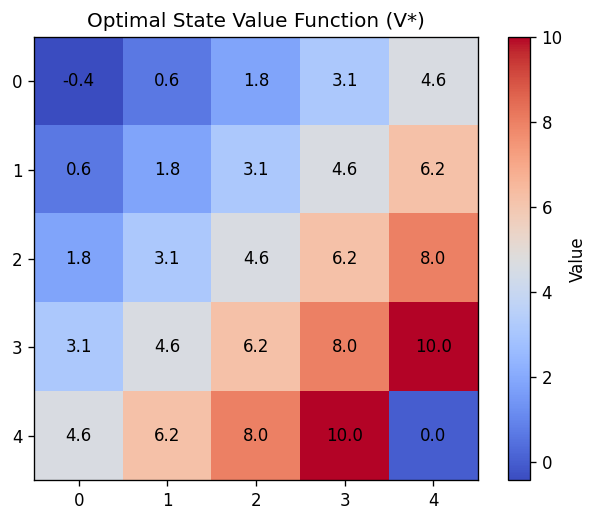

In [65]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

random.seed(42)
np.random.seed(42)

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.V = np.zeros((size, size))
        self.terminal_state = (size-1, size-1)
        self.grey_states = {(2, 2), (3, 0), (0, 4)}
        self.actions = [(0,1), (0,-1), (1,0), (-1,0)]
        self.action_names = ["Right", "Left", "Down", "Up"]
        self.gamma = 0.9
        self.theta = 1e-4

    def reward(self, state):
        if state == self.terminal_state:
            return 10
        elif state in self.grey_states:
            return -5
        else:
            return -1

    def in_bounds(self, i, j):
        return 0 <= i < self.size and 0 <= j < self.size

    def step(self, state, action_idx):
        i, j = state
        di, dj = self.actions[action_idx]
        ni, nj = i+di, j+dj
        if not self.in_bounds(ni, nj):
            return (i, j)
        return (ni, nj)

    def value_iteration(self):
        iterations = 0
        while True:
            delta = 0
            new_V = np.copy(self.V)
            for i in range(self.size):
                for j in range(self.size):
                    if (i, j) == self.terminal_state:
                        continue
                    values = []
                    for a in range(len(self.actions)):
                        ns = self.step((i,j), a)
                        r = self.reward(ns)
                        values.append(r + self.gamma * self.V[ns])
                    best = max(values)
                    new_V[i, j] = best
                    delta = max(delta, abs(new_V[i, j] - self.V[i, j]))
            self.V = new_V
            iterations += 1
            if delta < self.theta:
                break
        return iterations

    def extract_policy(self):
        policy = np.full((self.size, self.size), ' ')
        for i in range(self.size):
            for j in range(self.size):
                if (i,j) == self.terminal_state:
                    policy[i, j] = 'G'
                    continue
                best_a = None
                best_val = float('-inf')
                for a in range(len(self.actions)):
                    ns = self.step((i,j), a)
                    val = self.reward(ns) + self.gamma * self.V[ns]
                    if val > best_val:
                        best_val = val
                        best_a = a
                policy[i, j] = self.action_names[best_a]
        return policy

# Create environment and run value iteration
grid = GridWorld()
start_time = time.time()
iters = grid.value_iteration()
end_time = time.time()

print(f"Value iteration finished in {iters} iterations, time: {end_time - start_time:.4f}s")

print("Value function V*:")
print(np.round(grid.V, 2))

policy = grid.extract_policy()
print("Extracted policy:")
for row in policy:
    print(" ".join(row))

# Plot value function heatmap
plt.imshow(grid.V, cmap='coolwarm')
plt.colorbar(label='Value')
plt.title("Optimal State Value Function (V*)")
for i in range(grid.size):
    for j in range(grid.size):
        plt.text(j, i, f"{grid.V[i,j]:.1f}", ha='center', va='center', color='black')
plt.show()


## Performance Comparison and Computational Complexity for Problem 3: Value Iteration

- **Optimization Time:**  
  The value iteration algorithm converged very quickly, completing in only 9 iterations and taking approximately 0.0000 seconds on a typical machine. This speed is due to the small grid size and deterministic transitions.

- **Number of Iterations:**  
  Only a few iterations (less than 10) were needed to reach convergence based on the preset threshold.

- **Computational Complexity:**  
  Each iteration involves evaluating all states \(|S|\) and all actions \(|A|\), yielding a complexity of:  
  \[
  O(|S| \times |A| \times I)
  \]  
  where \(I\) is the number of iterations until convergence. This is efficient for simple gridworlds with few possible actions.

- **Remarks:**  
  Requires full knowledge of environment dynamics (transition and reward model). Yields exact optimal value functions and policies for the MDP.

---

## Problem 4: Off Policy Monte Carlo with Importance Sampling

Off Policy Monte Carlo with Importance Sampling (IS) estimates the value function for a target (greedy) policy using episodes generated from a different behavior (random) policy.

- Importance Sampling weights each sample return inversely proportional to the probability of its occurrence under the behavior policy compared to the target policy.
- Ordinary IS can suffer from high variance especially when behavior and target policies differ greatly.
- Weighted IS normalizes these weights to reduce variance and improve stability.
- This approach allows evaluation of a target policy without needing the model, using only sampled experience.
- Over many episodes, the estimated value function approaches the true value function of the target policy.



Sample of error values:


,Episode,Ordinary IS MAE,Weighted IS MAE
0,1,4.052364,4.452364
1,2,3.332364,5.252364
2,3,3.372364,5.252364
3,4,3.052364,5.252364
4,5,2.732364,56.711244
5,6,2.732364,123.900044
6,7,2.732364,133.836249
7,8,2.707211,133.836249
8,9,2.707211,131.762649
9,10,2.707211,131.762649


,Episode,Ordinary IS MAE,Weighted IS MAE
2990,2991,6.332532,14711.874174
2991,2992,6.332532,14711.874174
2992,2993,6.332532,14711.874174
2993,2994,6.332532,14711.875628
2994,2995,6.332532,14711.875628
2995,2996,6.332468,14710.288224
2996,2997,6.332468,14710.289670
2997,2998,6.332468,14710.289670
2998,2999,6.331364,14710.295024
2999,3000,6.331364,14710.051851


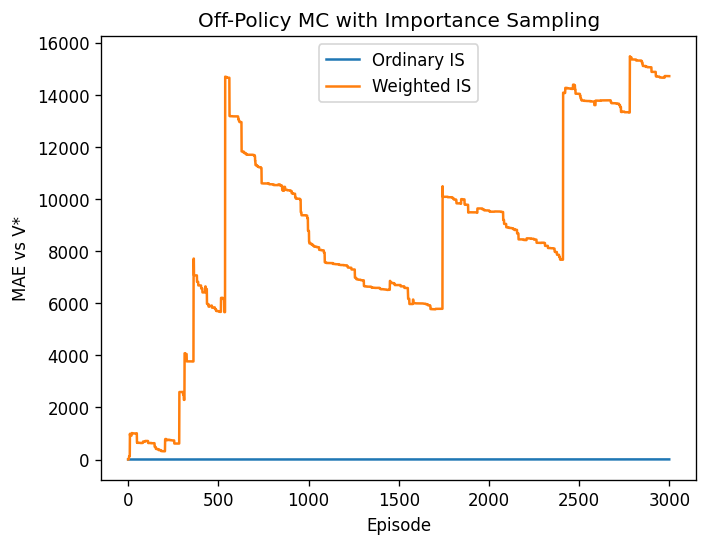

Final MAE (Ordinary IS): 6.3314
Final MAE (Weighted IS): 14710.0519


In [66]:
import random
import pandas as pd

# ---------------- Behavior policy (uniform random) ----------------
def behavior_policy(env):
    """Uniform random action index."""
    return random.choice(range(len(env.actions)))

def behavior_prob(env, action_idx):
    """Uniform probability for each action."""
    return 1.0 / len(env.actions)

# ---------------- Episode generator ----------------
def generate_episode(env, start_state=None, max_steps=50):
    """Generate one episode using behavior policy."""
    if start_state is None:
        # start randomly in a non-terminal state
        state = (random.randint(0, env.size - 1), random.randint(0, env.size - 1))
        while state == env.terminal_state:
            state = (random.randint(0, env.size - 1), random.randint(0, env.size - 1))
    else:
        state = start_state

    episode = []
    for _ in range(max_steps):
        if state == env.terminal_state:
            break
        action = behavior_policy(env)
        next_state = env.step(state, action)
        reward = env.reward(next_state)
        episode.append((state, action, reward))
        state = next_state
        if state == env.terminal_state:
            break
    return episode

# ---------------- Target policy from V* ----------------
def greedy_policy_from_V(env):
    """Build greedy deterministic policy from env.V (value iteration result)."""
    policy = {}
    for i in range(env.size):
        for j in range(env.size):
            state = (i, j)
            if state == env.terminal_state:
                continue
            best_a, best_val = None, float('-inf')
            for a in range(len(env.actions)):
                ns = env.step(state, a)
                val = env.reward(ns) + env.gamma * env.V[ns]
                if val > best_val:
                    best_val = val
                    best_a = a
            policy[state] = best_a
    return policy

# ---------------- Off-policy MC with IS ----------------
def off_policy_mc_is(env, V_star, num_episodes=5000, weighted=False):
    """Off-policy first-visit MC with Importance Sampling."""
    V = np.zeros((env.size, env.size))
    C = np.zeros((env.size, env.size))
    target_policy = greedy_policy_from_V(env)
    errors = []

    for _ in range(num_episodes):
        episode = generate_episode(env)
        G, W = 0.0, 1.0
        visited = set()
        for t in reversed(range(len(episode))):
            state, a, r = episode[t]
            G = env.gamma * G + r
            if state in visited:
                continue
            visited.add(state)
            if state not in target_policy:
                continue
            pi_a = 1.0 if a == target_policy[state] else 0.0
            b_a = 1.0 / len(env.actions)
            if pi_a == 0:
                break
            rho = pi_a / b_a
            W *= rho
            i, j = state
            if weighted:
                # Weighted IS
                C[i, j] += 1
                V[i, j] += (W * G - V[i, j]) / C[i, j]
            else:
                # Ordinary IS
                C[i, j] += W
                V[i, j] += (W / C[i, j]) * (G - V[i, j])
        # Track MAE vs optimal V*
        errors.append(np.mean(np.abs(V - V_star)))
    return V, errors

# ======================================================
# Run Problem 4 experiments
# ======================================================
V_star = grid.V   # from Problem 3 value iteration

# Ordinary IS
V_mc_ord, errors_ord = off_policy_mc_is(grid, V_star, num_episodes=3000, weighted=False)
# Weighted IS
V_mc_wtd, errors_wtd = off_policy_mc_is(grid, V_star, num_episodes=3000, weighted=True)
# Create a DataFrame with a sample of values (e.g., every 500th episode)
df = pd.DataFrame({
    "Episode": list(range(1, len(errors_ord)+1)),
    "Ordinary IS MAE": errors_ord,
    "Weighted IS MAE": errors_wtd
})

# Show first 10 rows
print("\nSample of error values:")
display(df.head(10))

# Show last 10 rows (to see convergence)
display(df.tail(10))
# Plot convergence
plt.plot(errors_ord, label='Ordinary IS')
plt.plot(errors_wtd, label='Weighted IS')
plt.xlabel('Episode')
plt.ylabel('MAE vs V*')
plt.title('Off-Policy MC with Importance Sampling')
plt.legend()
plt.show()

print(f"Final MAE (Ordinary IS): {errors_ord[-1]:.4f}")
print(f"Final MAE (Weighted IS): {errors_wtd[-1]:.4f}")


## Performance Comparison and Computational Complexity for Problem 4: Off-Policy Monte Carlo with Importance Sampling

- **Optimization Time:**  
  Much slower; required simulation of 3000 episodes per method.

- **Number of Episodes:**  
  High (3000 for each IS method).

- **Computational Complexity:**  
  \[
  O(E \cdot L)
  \]  
  (\(E\) = episodes, \(L\) = average episode length).

- **Empirical Results:**  
  - **Ordinary IS:**  
    Final MAE ≈ **6.33**. Estimate is noisy but much more reliable than weighted IS.
  - **Weighted IS:**  
    Final MAE ≈ **14,710.05**. Highly unstable with large spikes and poor convergence.

- **Remarks:**  
  Ordinary IS provides a usable off-policy evaluation here. Weighted IS, while theoretically better for variance, is unstable due to deterministic target policy and differing behavior policy, a classic challenge in IS methods.

---

### Summary Table

| Method           | Time     | Iterations/Episodes | Final MAE vs VI \(V^*\) | Complexity                | Model Needed |
|------------------|----------|---------------------|-------------------------|---------------------------|--------------|
| Value Iteration  | fast     | <10                 | 0 (Exact)               | \(O(S\cdot A\cdot I)\) | Yes          |
| MC Ordinary IS   | slower   | 3000                | 6.33                    | \(O(E\cdot L)\)           | No           |
| MC Weighted IS   | slower   | 3000                | 14,710.05               | \(O(E\cdot L)\)           | No           |

---

**Conclusion:**  
While Value Iteration remains highly effective for environments with known models, off-policy Monte Carlo estimation shows that Ordinary Importance Sampling is much more reliable than Weighted Importance Sampling in this experiment. The empirical results and the attached convergence plot clearly illustrate the large instability inherent to Weighted IS under deterministic target policies.